# Convolutional neural networks

multiclass -> softmax activation function

# Bonus task: Чем различается Бинарная кроинтропия и обычная кроссинтропия?


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tqdm

import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import keras
from torch.utils.data import DataLoader,Dataset
from PIL import Image

In [2]:
from numpy import load

In [3]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [4]:
torch.cuda.is_available()

# wget https://developer.download.nvidia.com/compute/cuda/repos/wsl-ubuntu/x86_64/cuda-wsl-ubuntu.pin
# sudo mv cuda-wsl-ubuntu.pin /etc/apt/preferences.d/cuda-repository-pin-600
# wget https://developer.download.nvidia.com/compute/cuda/11.7.0/local_installers/cuda-repo-wsl-ubuntu-11-7-local_11.7.0-1_amd64.deb
# sudo dpkg -i cuda-repo-wsl-ubuntu-11-7-local_11.7.0-1_amd64.deb
# sudo apt-get update
# sudo apt-get -y install cuda

True

In [5]:
import os
directory = 'fishes'
clases = os.listdir(directory)

In [6]:
clases = clases[:3]

In [7]:
train_files = []
target_files = []
for fish_type in clases: 
    for file in os.listdir(os.path.join(directory, fish_type)):
        train_files.append(os.path.join(directory, fish_type, file))
        target_files.append(fish_type)

In [8]:
df = pd.DataFrame({'img' : train_files, 'target' : target_files})
df.head()

,img,target
0,fishes/Red Mullet/00008.png,Red Mullet
1,fishes/Red Mullet/00032.png,Red Mullet
2,fishes/Red Mullet/00027.png,Red Mullet
3,fishes/Red Mullet/00016.png,Red Mullet
4,fishes/Red Mullet/00036.png,Red Mullet


In [9]:
img = []
for ind in tqdm.tqdm(range(len(df['img']))):
    origImage = cv2.imread(df['img'][ind])
    origImage = cv2.resize(origImage, (256, 256))
    img.append(origImage)
df['img'] = img

df.head()

100%|██████████| 150/150 [00:02<00:00, 52.26it/s] 


,img,target
0,"[[[125, 101, 64], [125, 99, 73], [125, 103, 67...",Red Mullet
1,"[[[28, 26, 21], [26, 23, 18], [25, 21, 16], [2...",Red Mullet
2,"[[[89, 70, 39], [112, 89, 69], [112, 85, 72], ...",Red Mullet
3,"[[[125, 100, 58], [123, 90, 65], [127, 94, 59]...",Red Mullet
4,"[[[114, 96, 63], [118, 92, 62], [122, 95, 65],...",Red Mullet


In [10]:
torch.cuda.is_available()

True

In [11]:
y = []
for i in range(len(df['target'])):
    for j in range(len(clases)):
        if df['target'][i] == clases[j]:
            y.append(j)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img, y, test_size=0.2, random_state=10)

y_train

[1,
 1,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 2,
 1,
 2,
 0,
 2,
 0,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 1,
 0,
 2,
 1,
 1,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 0,
 0,
 0,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 2,
 0,
 1,
 1,
 2,
 2,
 0,
 1,
 2,
 2,
 1,
 1,
 2,
 0,
 2,
 0,
 0,
 1,
 0,
 2,
 2,
 2,
 1,
 0,
 2,
 0]

In [526]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt  
class MyDataset(Dataset):
    def __init__(self, data, targets,transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)
%matplotlib inline
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(X_train,y_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test,y_test, transform=transform)
testloader = DataLoader(testset, batch_size=4)

In [527]:
class MyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)        

        self.fc1 = nn.Linear(61 * 61 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 61 * 61 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [528]:
# if torch.cuda.is_available():
#   net = MyConvNet().cuda()
# else:
  # net = MyConvNet() 
net = MyConvNet()
batch = []

batch = next(iter(trainloader))
print(batch[0].shape)

torch.Size([4, 3, 256, 256])


In [529]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [530]:

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
train_losses = []
test_losses = []
running_loss = 0
# итерируемся
for epoch in (range(13)):
    train_loss = []
    test_loss = []
    for i, batch in enumerate(trainloader):
        X_batch, y_batch = batch
        X_batch = X_batch.to(device=device, dtype=torch.float32)
        y_batch = y_batch.to(device = device, dtype = torch.long)
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        net.train(False)

    with torch.no_grad():
        for i, batch in enumerate(testloader):
            X_test_batch, y_pred_batch = batch
            X_test_batch = X_test_batch.to(device=device, dtype=torch.float32)
            y_pred_batch = y_pred_batch.to(device = device, dtype = torch.long)
            y_test_pred = net(X_test_batch)
            test_l = loss_fn(y_test_pred, y_pred_batch)
            test_loss.append(test_l.item())
    train_losses.append(np.mean(train_loss))
    test_losses.append(np.mean(test_loss))
    print('epoch ',epoch, ' train_loss ',np.mean(np.mean(train_loss)), ' test_loss ',np.mean(test_loss))


epoch  0  train_loss  1.0927065451939901  test_loss  1.0708321928977966
epoch  1  train_loss  0.9963608503341674  test_loss  0.9579183533787727
epoch  2  train_loss  0.7751718501249949  test_loss  0.7341331616044044
epoch  3  train_loss  0.5418528378009796  test_loss  0.6124518774449825
epoch  4  train_loss  0.38128572230537733  test_loss  0.5189071670174599
epoch  5  train_loss  0.279768297324578  test_loss  0.4591177701950073
epoch  6  train_loss  0.20903512816876174  test_loss  0.4074780335649848
epoch  7  train_loss  0.16072831843048335  test_loss  0.3739199675619602
epoch  8  train_loss  0.12935570273548364  test_loss  0.36200365936383605
epoch  9  train_loss  0.10977737045225998  test_loss  0.36554632778279483
epoch  10  train_loss  0.10074968993042906  test_loss  0.3827554553281516
epoch  11  train_loss  0.10035035526379943  test_loss  0.42208297713659704
epoch  12  train_loss  0.10586883262731135  test_loss  0.47380182170309126


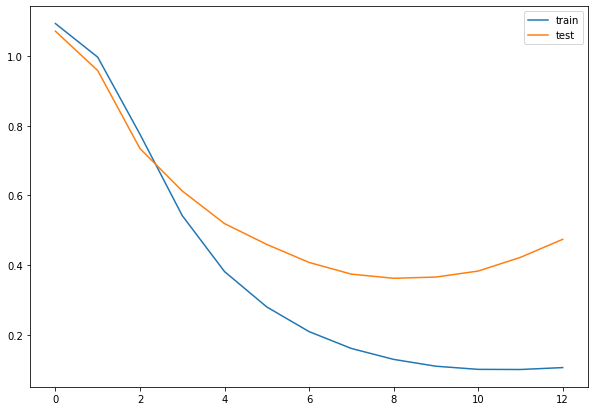

In [531]:
plt.figure(figsize=(10,7))
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()

In [532]:
y_pred = []
#Test your model on X_test data and show confusion_matrix and classification_report

with torch.no_grad():
    for i, batch in enumerate(testloader):
        X_test_batch, y_pred_batch = batch
        X_test_batch = X_test_batch.to(device=device, dtype=torch.float32)
        y_test_pred = net(X_test_batch)
        y_pred.extend(y_test_pred.argmax(dim=1).cpu().numpy())

In [533]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

[[10  0  0]
 [ 0 13  0]
 [ 4  0  3]]
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       1.00      1.00      1.00        13
           2       1.00      0.43      0.60         7

    accuracy                           0.87        30
   macro avg       0.90      0.81      0.81        30
weighted avg       0.90      0.87      0.85        30

